# European Options Pricing Using the BSM Model

In this project, we will be filling in an options book of missing values which includes implied volatility and basic Greeks. The formulas for the Greeks as well as the fair value for calls and puts can be found here: https://en.wikipedia.org/wiki/Greeks_(finance)#Formulas_for_European_option_Greeks.

First we need to import the necessary imports and give values for a few necessary variables. These variables include the stock's current tick price, the guaranteed interest rate, the dividend yield of the stock, and finally the time to expiration of the contracts in the units of years. From these values, we can easily calculate the forward price of the asset. 

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import math
import time
import matplotlib.pyplot as plt

# Inputs
S = 3998.75 # Stock Price
R = 0.0463338426957343 # Interest Rate (Guaranteed)
Q = 0.0178246010503463 # Dividend Yield
T = 43/252 # Time till expiration (in years)

print("Forward Price =",S*np.exp((R-Q)*T))

Forward Price = 4018.2499999999995


## Make Helper Functions and Read In Data
In the next cell, a few helper functions are defined. The 2 Phis are the cumulative distribution function and probability distribution function of a normal curve. These will be used to solve for many different formulas. The bsCalls function returns the price of a call given certain inputs. The Vega function calculates the Vega Greek given inputs. Finally, the impVolCall finds the implied volatility for calls and puts. This model assumes all price disturbances from normalacy is due to higher implied volatility. In the real world however, there can be multiple factors that can affect the price of an option from the normal distribution price. Its worth noticing that we need to find the implied volatility for every strike price before we can calculate any of the Greeks. Since there isn't a closed form solution to finding the implied volatility, we will have to iterate through implied volatilities to find the exact number. This method is a version of Newton's optimization method called the Newton-Raphson method. This sort of iteration is better than brute force and is more optimal. The tolerance for the final implied volatility can be adjusted as well as the number of iterations. Decreasing tolerance and increasing the iterations will obviously increase computing time so make a note of that. 

The options book is then read in as a pandas dataframe. 

In [2]:
Phi = norm.cdf
phi = norm.pdf

def bsCalls(S, K, T, R, Q, vol):
    d1 = (math.log(S/K)+(R-Q+0.5*vol**2)*T)/(vol*T**0.5)
    d2 = d1-vol*T**0.5
    return S*np.exp(-Q*T)*Phi(d1) - np.exp(-R*T)*K*Phi(d2)

def Vega(S, K, T, R, Q, vol):
    d1 = (math.log(S/K)+(R-Q+0.5*vol**2)*T)/(vol*T**0.5)
    return S*np.exp(-Q*T)*phi(d1)*(T**0.5)

#Calculating using Newton Raphson
def impVolCall(price, S, K, T, R, Q, tolerance = 0.000000000001, maxIter = 400):
    vol = 0.2
    for i in range(maxIter):
        diff = bsCalls(S, K, T, R, Q, vol) - price
        if abs(diff)<tolerance:
            break
        changeVol = diff/Vega(S, K, T, R, Q, vol)
        vol = vol - changeVol
    if math.isnan(vol):
        vol = 0.45
        for i in range(maxIter):
            diff = bsCalls(S, K, T, R, Q, vol) - price
            if abs(diff)<tolerance:
                break
            changeVol = diff/Vega(S, K, T, R, Q, vol)
            vol = vol - changeVol
    return vol

book = pd.read_csv("options book.csv")

To help store information, we can use a python dictionaries to hold the values for every strike. 

In [3]:
# Convert Strikes and Prices to Dictionary
bookDict = {}
for i in range(len(book)):
    bookDict[book["Strike"][i]] = {"Call": book["Call Value"][i], "Put": book["Put Value"][i]} 

Now we fill in the rest of the options book. This process will take around 5-10 seconds to compute.

In [5]:
# Fill the rest of the book
t1 = time.time()
for strike in bookDict:
    cPrice = bookDict[strike]["Call"]
    bookDict[strike]["IV"] = impVolCall(cPrice, S, strike, T, R, Q)
    vol = bookDict[strike]["IV"]
    d1 = (math.log(S/strike)+(R-Q+0.5*vol**2)*T)/(vol*T**0.5)
    d2 = d1-vol*T**0.5
    bookDict[strike]["Call Delta"] = np.exp(-Q*T)*Phi(d1)
    bookDict[strike]["Put Delta"] = -np.exp(-Q*T)*Phi(-d1)
    bookDict[strike]["Gamma"] = np.exp(-Q*T)*phi(d1)/(S*vol*T**0.5)
    bookDict[strike]["Vega"] = S*np.exp(-Q*T)*phi(d1)*T**0.5
t2 = time.time()
print("Time to complete book:", round(t2-t1, 2), "seconds")

C:\windows\temp/ipykernel_31056/2510001283.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  changeVol = diff/Vega(S, K, T, R, Q, vol)
C:\windows\temp/ipykernel_31056/2510001283.py:5: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S/K)+(R-Q+0.5*vol**2)*T)/(vol*T**0.5)
C:\windows\temp/ipykernel_31056/2510001283.py:10: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S/K)+(R-Q+0.5*vol**2)*T)/(vol*T**0.5)
C:\windows\temp/ipykernel_31056/2510001283.py:5: RuntimeWarning: overflow encountered in double_scalars
  d1 = (math.log(S/K)+(R-Q+0.5*vol**2)*T)/(vol*T**0.5)
C:\windows\temp/ipykernel_31056/2510001283.py:10: RuntimeWarning: overflow encountered in double_scalars
  d1 = (math.log(S/K)+(R-Q+0.5*vol**2)*T)/(vol*T**0.5)


Time to complete book: 6.56 seconds


In [6]:
#Final Data Frame
finbook = pd.DataFrame.from_dict(bookDict).T
finbook

,Call,Put,IV,Call Delta,Put Delta,Gamma,Vega
1900,2101.904,0.335,0.618087,0.995864,-0.001099,0.000004,6.062577
2000,2002.778,0.422,0.590328,0.995541,-0.001422,0.000005,7.677241
2100,1903.665,0.521,0.562704,0.995149,-0.001814,0.000006,9.579458
2200,1804.569,0.637,0.535504,0.994670,-0.002293,0.000008,11.850960
2300,1705.493,0.774,0.508734,0.994082,-0.002881,0.000010,14.566101
...,...,...,...,...,...,...,...
5250,0.129,1222.179,0.212406,0.001330,-0.995633,0.000012,7.221292
5275,0.122,1246.975,0.214814,0.001250,-0.995713,0.000012,6.821993
5300,0.115,1271.771,0.217128,0.001172,-0.995792,0.000011,6.429108
5325,0.109,1296.569,0.219505,0.001103,-0.995860,0.000010,6.085959


## Save the Options Books and Investigate the Calculated Values

Since options are complex derivatives, its worth seeing how each variable changes with strike price. We will also save the options book as a csv file if we need to refer to it in the future. 

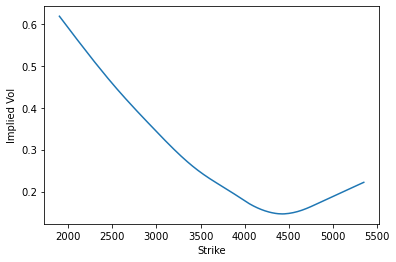

In [8]:
finbook.to_csv("OptimizedOptions.csv")
plt.plot(finbook["IV"])
plt.xlabel("Strike")
plt.ylabel("Implied Vol")
pass

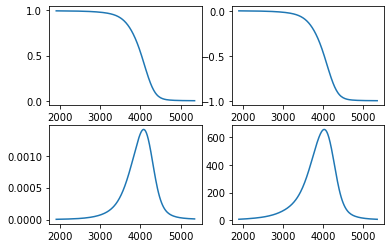

In [10]:
# Call Delta and Put Delta in first row, Gamma and Vega in second row
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(finbook["Call Delta"])
axs[0, 1].plot(finbook["Put Delta"])
axs[1, 0].plot(finbook["Gamma"])
axs[1, 1].plot(finbook["Vega"])
pass

## Conclusion
This project helped me familiarize myself with the basic Black-Scholes-Merton model as well as values associated with it including volatility and options Greeks. While this was an interesting project, there isn't much value generated by creating this model as most firms use different versions of the BSM model with more complex inputs. Thus a future direction for this project is creating my own augmented BSM model to help align the model better to current market prices and movements. 